<a href="https://colab.research.google.com/github/cfong32/data6100-final-proj/blob/master/data6100_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!wget -q --show-progress -O new-york-city-taxi-fare-prediction.zip https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESnzvg-NHEhPgoURZmVYv1MBUS3GVlHGGUTbnBRS10J3Eg?download=1
!unzip new-york-city-taxi-fare-prediction.zip

new-york-city-taxi- 100%[===================>]   1.56G  77.5MB/s    in 23s     
Archive:  new-york-city-taxi-fare-prediction.zip
replace GCP-Coupons-Instructions.rtf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.min_rows', 4)

# Read data (train + test)

In [15]:
# Helper function to calculate distance

def compute_dist(df):
    # source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    lat1 = df.pickup_latitude.map(np.deg2rad).values
    lon1 = df.pickup_longitude.map(np.deg2rad).values
    lat2 = df.dropoff_latitude.map(np.deg2rad).values
    lon2 = df.dropoff_longitude.map(np.deg2rad).values

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6373.0
    dist = R * c
    return dist

In [20]:
# Read dataset (train + test)

df = (
    pd.concat([
        (pd.read_csv('train.csv', nrows=100_000)    # read nrows ONLY, the whole set contains >55M rows
         .assign(dataset='train')),
        (pd.read_csv('test.csv')
         .assign(dataset='test')),
    ])
    .assign(
        pickup_datetime=lambda x: pd.to_datetime(x.pickup_datetime),
        year   =lambda x: x.pickup_datetime.dt.year,
        month  =lambda x: x.pickup_datetime.dt.month,
        day    =lambda x: x.pickup_datetime.dt.day,
        weekday=lambda x: x.pickup_datetime.dt.weekday,
        hour   =lambda x: x.pickup_datetime.dt.hour,
        minute =lambda x: x.pickup_datetime.dt.minute,
        dist   =lambda x: compute_dist(x),
     )
)
trainset = df.dataset == 'train'
testset  = df.dataset == 'test'

print(f'train: {trainset.sum()}, test: {testset.sum()}')
display(df)

train: 100000, test: 9914


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,year,month,day,weekday,hour,minute,dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,train,2009,6,15,0,17,26,1.031088
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1,5,1,16,52,8.452786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,2015-01-31 01:05:19.0000005,NaN,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,test,2015,1,31,5,1,5,8.346106
9913,2015-01-18 14:06:23.0000006,NaN,2015-01-18 14:06:23+00:00,-73.988022,40.754070,-74.000282,40.759220,6,test,2015,1,18,6,14,6,1.181196


In [21]:
# Simple description of train and test data

df.groupby('dataset').describe().stack()

fare_amount  pickup_longitude  pickup_latitude  \
dataset                                                           
test    count       0.000000       9914.000000      9914.000000   
        mean             NaN        -73.974722        40.751041   
        std              NaN          0.042774         0.033541   
        min              NaN        -74.252193        40.573143   
        25%              NaN        -73.992501        40.736125   
        50%              NaN        -73.982326        40.753051   
        75%              NaN        -73.968013        40.767113   
        max              NaN        -72.986532        41.709555   
train   count  100000.000000     100000.000000    100000.000000   
        mean       11.354652        -72.494682        39.914481   
        std         9.716777         10.693934         6.225686   
        min       -44.900000       -736.550000       -74.007670   
        25%         6.000000        -73.992041        40.734996   
        50%         8.500000        -73.981789        40.752765   
        75%        12.500000        -73.966982        40.767258   
        max       200.000000         40.787575       401.083332   

               dropoff_longitude  dropoff_latitude  passenger_count  \
dataset                                                               
test    count        9914.000000       9914.000000      9914.000000   
        mean          -73.973657         40.751743         1.671273   
        std             0.039072          0.035435         1.278747   
        min           -74.263242         40.568973         1.000000   
        25%           -73.991247         40.735254         1.000000   
        50%           -73.980015         40.754065         1.000000   
        75%           -73.964059         40.768757         2.000000   
        max           -72.990963         41.696683         6.000000   
train   count      100000.000000     100000.000000    100000.000000   
        mean          -72.490967         39.919053         1.673820   
        std            10.471386          6.213427         1.300171   
        min           -84.654241        -74.006377         0.000000   
        25%           -73.991215         40.734182         1.000000   
        50%           -73.980000         40.753243         1.000000   
        75%           -73.963433         40.768166         2.000000   
        max            40.851027        404.616667         6.000000   

                        year          month            day        weekday  \
dataset                                                                     
test    count    9914.000000    9914.000000    9914.000000    9914.000000   
        mean     2011.815816       6.857979      16.194170       2.852834   
        std         1.803347       3.353272       8.838482       1.994451   
        min      2009.000000       1.000000       1.000000       0.000000   
        25%      2010.000000       4.000000       9.000000       1.000000   
        50%      2012.000000       7.000000      16.000000       3.000000   
        75%      2014.000000      10.000000      25.000000       5.000000   
        max      2015.000000      12.000000      31.000000       6.000000   
train   count  100000.000000  100000.000000  100000.000000  100000.000000   
        mean     2011.743890       6.261230      15.664270       3.036180   
        std         1.866020       3.450569       8.677631       1.949484   
        min      2009.000000       1.000000       1.000000       0.000000   
        25%      2010.000000       3.000000       8.000000       1.000000   
        50%      2012.000000       6.000000      16.000000       3.000000   
        75%      2013.000000       9.000000      23.000000       5.000000   
        max      2015.000000      12.000000      31.000000       6.000000   

                        hour         minute           dist  
dataset                                                     
test    count    9914.

<font color="#FF0000">Note that some training data is **out of range** -- outside the range of test data.<font/>

# Preprocess data
- Select some input features
- Remove irrelevant data from training set
    - **Keep training data which is within the range of test data**

In [22]:
# Input and output variables
cols_X = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'year',
    'month',
    'day',
    'weekday',
    'hour',
    'minute',
    'dist',
]
col_y = 'fare_amount'

# Determine
# which record is out-of-range -- to drop
# which record is within-range -- to keep

testset_max = df[testset][cols_X].max()    # max values in test set
testset_min = df[testset][cols_X].min()    # min values in test set

trainset_to_drop = (trainset
                    &
                    ((df[cols_X] > testset_max).any(axis=1)     # > max
                     |
                     (df[cols_X] < testset_min).any(axis=1))    # or < min
                   )
trainset_to_keep = trainset & ~trainset_to_drop

print(f'train: {trainset.sum()}, test: {testset.sum()}')
print('train to drop:', trainset_to_drop.sum(), 'train to keep:', trainset_to_keep.sum())

train: 100000, test: 9914
train to drop: 2517 train to keep: 97483


In [23]:
# Make sure there is no NA
assert df[trainset_to_keep][cols_X].notna().all().all()
assert df[trainset_to_keep][col_y].notna().all().all()

# Standardize X and y  (X_train and y_train)
sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
X_train = ((df[trainset_to_keep][cols_X] - sr_mean_X) / sr_std_X).values
y_train = df[trainset_to_keep][col_y].values

X_train.shape, y_train.shape

((97483, 12), (97483,))

# Train a *fare_amount ~ dist* linear model

In [28]:
# Evaluate performnace using CV

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X_train_dist_only = X_train[:,[-1]]
model = LinearRegression()
scores = -cross_val_score(model,
                          X_train_dist_only,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [6.07551534 5.28855513 6.08344327 5.26650932 5.28153184]
Mean cross-validation score: 5.599110979519088


In [68]:
# Fit a model to obtain learned parameters

model.fit(X_train_dist_only, y_train)
y_hat = model.predict(X_train_dist_only)
y_residual = y_train - y_hat

beta = model.coef_[0]
offset = model.intercept_
print(f'Model equation:')
print(f'fare_amount = dist * {beta} + {offset}')

Model equation:
fare_amount = dist * 713.73200109713 + 40.472861661930104


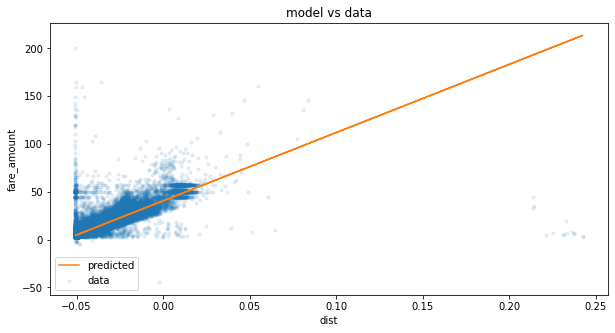

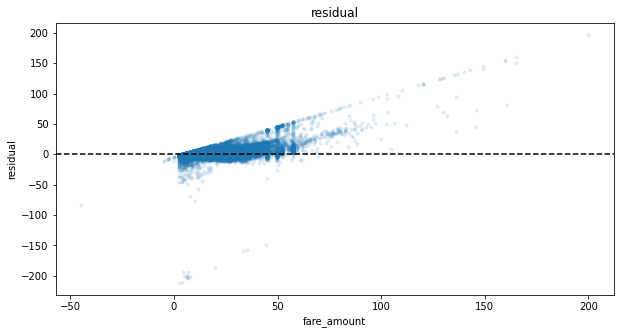

In [73]:
# Visualize model performance

plt.figure(figsize=(10,5))
plt.scatter(X_train_dist_only, y_train, label='data', alpha=0.1, marker='.', color='C0')
plt.plot(X_train_dist_only, y_hat, label='predicted', color='C1')
plt.title('model vs data')
plt.ylabel('fare_amount')
plt.xlabel('dist')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(y_train, y_residual, label='data', alpha=0.1, marker='.', color='C0')
plt.axhline(0, color='k', ls='--')
plt.title('residual')
plt.ylabel('residual')
plt.xlabel('fare_amount')
plt.show()

# Evaluate some models

In [ ]:
# Logistic Regression

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [7.98677275 8.14558127 8.16869135 8.2101265  8.30146526]
Mean cross-validation score: 8.16252742260408


In [ ]:
# Histogram-based Gradient Boosting Regression Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [4.14631332 4.49560691 4.61356453 4.48967955 4.25663139]
Mean cross-validation score: 4.400359138802013


# Fit a final model

In [ ]:
# Final model

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

X_test = ((df[testset][cols_X] - sr_mean_X) / sr_std_X).values
y_hat = model.predict(X_test)

X_test.shape, y_hat.shape

((9914, 11), (9914,))

# Make a submission CSV

In [ ]:
import pytz
from datetime import datetime, timezone

# make submission csv
df_submission = pd.DataFrame({
    'key'        : df[testset]['key'],
    'fare_amount': y_hat,
})

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
save_path = f'submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2211271646.csv


# Keep some records (for ourselves)

- HBGR.submission.2211271646.csv
    - **Histogram-based Gradient Boosting Regression Tree**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **3.79107**
- LR.submission.2212271557.csv
    - **Simple linear regression**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **7.93275**

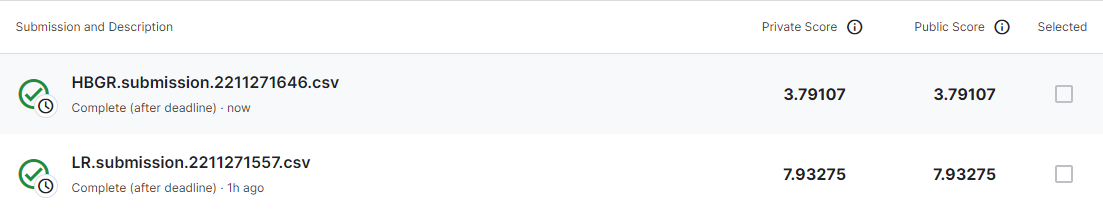